## Homework 5
### NLP Pipelines

Welcome to Homework 5! 

The homework contains several tasks. You can find the amount of points that you get for the correct solution in the task header. Maximum amount of points for each homework is _four_.

The **grading** for each task is the following:
- correct answer - **full points**
- insufficient solution or solution resulting in the incorrect output - **half points**
- no answer or completely wrong solution - **no points**

Even if you don't know how to solve the task, we encourage you to write down your thoughts and progress and try to address the issues that stop you from completing the task.

When working on the written tasks, try to make your answers short and accurate. Most of the times, it is possible to answer the question in 1-3 sentences.

When writing code, make it readable. Choose appropriate names for your variables (`a = 'cat'` - not good, `word = 'cat'` - good). Avoid constructing lines of code longer than 100 characters (79 characters is ideal). If needed, provide the commentaries for your code, however, a good code should be easily readable without them :)

Finally, all your answers should be written only by yourself. If you copy them from other sources it will be considered as an academic fraud. You can discuss the tasks with your classmates but each solution must be individual.

<font color='red'>**Important!:**</font> **before sending your solution, do the `Kernel -> Restart & Run All` to ensure that all your code works.**

In [1]:
!pip install --quiet datasets stanza conllu networkx torchmetrics

In [2]:
from datasets import load_dataset
import stanza
import re
import matplotlib.pyplot as plt

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
from torchmetrics.functional import f1_score
from tqdm.notebook import tqdm
import json

Load [Relation Extraction on SemEval-2010 Task 8](https://huggingface.co/datasets/sem_eval_2010_task_8) dataset.

In this dataset, two words are marked with `<e1></e1>` and `<e2></e2>` symbols, and the label is a relation between them.

For example:

`The <e1>student</e1> <e2>association</e2> is the voice of the undergraduate student population of the State University of New York at Buffalo.` 

`(Member-Collection(e1,e2))`

In [3]:
dataset = load_dataset("sem_eval_2010_task_8")

Using custom data configuration default
Reusing dataset sem_eval2010_task8 (/root/.cache/huggingface/datasets/sem_eval2010_task8/default/1.0.0/8545d1995bbbade386acf5c4e2bef5589d8387ae0a93356407dfb54cdb234416)


  0%|          | 0/2 [00:00<?, ?it/s]

Load the Stanza pipeline.

In [4]:
stanza.download('en')

2022-03-14 21:49:30 INFO: Downloading default packages for language: en (English)...
2022-03-14 21:49:34 INFO: File exists: /root/stanza_resources/en/default.zip.
2022-03-14 21:49:43 INFO: Finished downloading models and saved to /root/stanza_resources.


In [5]:
nlp = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse', tokenize_no_ssplit=True)

2022-03-14 21:49:48 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-03-14 21:49:48 INFO: Use device: gpu
2022-03-14 21:49:48 INFO: Loading: tokenize
2022-03-14 21:49:51 INFO: Loading: pos
2022-03-14 21:49:51 INFO: Loading: lemma
2022-03-14 21:49:51 INFO: Loading: depparse
2022-03-14 21:49:52 INFO: Done loading processors!


### Task 1. Replace the entities (0.5 points)

Write a function to replace that entity tags and the text between them into `ENTITY1` and `ENTITY2` accordingly.

For example:

Input: `The <e1>student</e1> <e2>association</e2> is the voice of the undergraduate student population of the State University of New York at Buffalo.`

Output: `The ENTITY1 ENTITY2 is the voice of the undergraduate student population of the State University of New York at Buffalo.`

In [7]:
def replace_entities(text):
    ### YOUR CODE HERE
    import re
    pattern = re.compile(r"</?e\d+>")
    sent = text.split()
    for i in range(len(sent)):
      if pattern.search(sent[i]):
        digit=re.findall(r'\d+',sent[i])
        sent[i] =f'ENTITY{digit[0]}'
    text=" ".join(sent)
    return text

## Task 2. Preprocess the text. (1 point)

For each sentece in the dataset, create five outputs:
- Lowercased tokens
- Deprels for each token
- Relative position of each token to the first entity (as string)
- Relative position of each token to the second entity (as string)
- Labels

Example:

Input: `The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>`

Tokens: `['the',
  'system',
  'as',
  'described',
  'above',
  'has',
  'its',
  'greatest',
  'application',
  'in',
  'an',
  'arrayed',
  'entity1',
  'of',
  'antenna',
  'entity2',
  '.']`

Deprels: `['det',
  'nsubj',
  'mark',
  'acl',
  'advmod',
  'root',
  'nmod:poss',
  'amod',
  'obj',
  'case',
  'det',
  'amod',
  'obl',
  'case',
  'nmod',
  'flat',
  'punct']`

Position 1: `['-12',
  '-11',
  '-10',
  '-9',
  '-8',
  '-7',
  '-6',
  '-5',
  '-4',
  '-3',
  '-2',
  '-1',
  '0',
  '1',
  '2',
  '3',
  '4']`

Position 2: `['-15',
  '-14',
  '-13',
  '-12',
  '-11',
  '-10',
  '-9',
  '-8',
  '-7',
  '-6',
  '-5',
  '-4',
  '-3',
  '-2',
  '-1',
  '0',
  '1']`

In [8]:
def preprocess(dataset, pipeline):
    doc = pipeline('\n\n'.join([replace_entities(item['sentence']) for item in dataset]))
    sentences = []
    deprels = []
    pos_1 = []
    pos_2 = []
    relations = [item['relation'] for item in dataset]
    for sentence in doc.sentences:
        try:
            ent1_id = [word.id for word in sentence.words if 'ENTITY1' in word.text][0] # Position of the first entity
            ent2_id = [word.id for word in sentence.words if 'ENTITY2' in word.text][0] # Position of the second entity
        except IndexError as e:
            print([word.text for word in sentence.words])
            raise e

        ### YOUR CODE STARTS HERE
        sentences.append([word['text'] for word in sentence.to_dict()])
        deprels.append([word['deprel'] for word in sentence.to_dict()])
        pos_1.append([str( int(word['id'])-int(ent1_id)) for word in sentence.to_dict()])
        pos_2.append([str(int(word['id'])-int(ent2_id)) for word in sentence.to_dict()])
        ### YOUR CODE ENDS HERE

    return sentences, deprels, pos_1, pos_2, relations

Preprocess train and test sets.

In [9]:
train_sents, train_deprels, train_pos_1, train_pos_2, train_rels = preprocess(dataset['train'], nlp)
test_sents, test_deprels, test_pos_1, test_pos_2, test_rels = preprocess(dataset['test'], nlp)

Download and unzip word vectors.

In [10]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-03-14 21:53:05--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-14 21:53:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.08MB/s    in 2m 40s  

utime(glove.6B.zip.1): No such file or directory
2022-03-14 21:55:45 (5.14 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]

In [11]:
# Load the embeddings into the memory
glove_path = 'glove.6B.300d.txt'
glove_vecs = []
idx2token = []
with open(glove_path, encoding='utf-8') as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        vec = [float(x) for x in line[1:]]
        glove_vecs.append(vec)
        idx2token.append(word)

# Convert to tensor
glove_vecs = torch.tensor(glove_vecs)

# Put zero vector for padding and mean for unknown
glove_vecs = torch.vstack(
    [
        torch.zeros(1, glove_vecs.size(1)),
        torch.mean(glove_vecs, dim=0).unsqueeze(0),
        torch.rand(1, glove_vecs.size(1)),
        torch.rand(1, glove_vecs.size(1)),
        glove_vecs,
    ]
)

# Save the embeddings in Pytorch format
torch.save(glove_vecs, 'glove.6B.300d.pt')

# Add special pad and unk tokens to the vocab
PAD = '<pad>'
PAD_ID = 0
UNK = '<unk>'
UNK_ID = 1
E1 = 'entity1'
E1_ID = 2
E2 = 'entity2'
E2_ID = 3

idx2token = [PAD, UNK, E1, E2] + idx2token

# Save the vocab
json.dump(idx2token, open('idx2token.json', 'w', encoding='utf-8'))

0it [00:00, ?it/s]

In [12]:
token2idx = {token: idx for idx, token in enumerate(idx2token)}

Build vocabularies for deprels and relative positions.

In [13]:
deprel_idx2token = list(set([deprel for sent in train_deprels for deprel in sent]))
deprel_idx2token = [PAD, UNK] + deprel_idx2token
deprel_token2idx = {token: idx for idx, token in enumerate(deprel_idx2token)}

In [14]:
pos_idx2token = list(set([pos for sent in train_pos_1 + train_pos_2 for pos in sent]))
pos_idx2token = [PAD, UNK] + pos_idx2token
pos_token2idx = {token: idx for idx, token in enumerate(pos_idx2token)}

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Convert text to ids, transform to pytorch tensors and pad to equal lengths.

In [16]:
def texts2ids(texts, token2idx, device):
    text_ids = []
    for text in texts:
        text_ids.append(torch.tensor([token2idx.get(token, UNK_ID) for token in text], dtype=torch.long))
    text_ids = pad_sequence(text_ids, batch_first=True, padding_value=PAD_ID)
    return text_ids.to(device)

In [17]:
train_sents_ids = texts2ids(train_sents, token2idx, device)
train_deprels_ids = texts2ids(train_deprels, deprel_token2idx, device)
train_pos_1_ids = texts2ids(train_pos_1, pos_token2idx, device)
train_pos_2_ids = texts2ids(train_pos_2, pos_token2idx, device)

test_sents_ids = texts2ids(test_sents, token2idx, device)
test_deprels_ids = texts2ids(test_deprels, deprel_token2idx, device)
test_pos_1_ids = texts2ids(test_pos_1, pos_token2idx, device)
test_pos_2_ids = texts2ids(test_pos_2, pos_token2idx, device)

In [18]:
train_rels = torch.tensor(train_rels, dtype=torch.long, device=device)
test_rels = torch.tensor(test_rels, dtype=torch.long, device=device)

Create a Dataset.

In [19]:
train_dataset = TensorDataset(train_sents_ids, train_deprels_ids, train_pos_1_ids, train_pos_2_ids, train_rels)
test_dataset = TensorDataset(test_sents_ids, test_deprels_ids, test_pos_1_ids, test_pos_2_ids, test_rels)

Randomly split the train set into 7000 sentences for train and 1000 for validation.

In [20]:
train_dataset, val_dataset = random_split(train_dataset, [7000, 1000], generator=torch.Generator().manual_seed(42))

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100)
test_dataloader = DataLoader(test_dataset, batch_size=100)

### Task 3. Modify the model. (2 points)

Add three more embedding layers that are randomly initialized. First one will encode the deprels, second encodes first relative positions and third encodes second relative position. The input size to each embedding layer is the size of corresponding vocabulary. The embedding size is specified by `deprel_emb_dim` argument.

Modify the `forward()` method. Encode each input with the corresponding embedding layer. After that, concatenate all the embeddings together.

In [31]:
class RelationClassificationModel(nn.Module):
    def __init__(self, pretrained_emb, deprel_idx2token, pos_idx2token, deprel_emb_dim, num_filters, kernel_sizes, num_classes):
        super().__init__()
        self.word_emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=PAD_ID, freeze=False)

        ### YOUR CODE STARTS HERE
        # Embedding layer for the deprels
        self.deprel_emb = nn.Embedding(len(deprel_idx2token), deprel_emb_dim, padding_idx=PAD_ID)
        # Embedding layer for the first positional embeddings
        self.pos_emb_1 = nn.Embedding(len(pos_idx2token), deprel_emb_dim, padding_idx=PAD_ID)
        # Embedding layer for the second positional embeddings
        self.pos_emb_2 = nn.Embedding(len(pos_idx2token), deprel_emb_dim, padding_idx=PAD_ID)
        # Concatenated embedding size
        emb_size = self.word_emb.weight.size(1) + (deprel_emb_dim *3)
        ### YOUR CODE ENDS HERE

        self.convs = nn.ModuleList(
            [
                  nn.Conv1d(in_channels=emb_size, out_channels=num_filters, kernel_size=kernel_size)
                  for kernel_size in kernel_sizes                  
            ]
        )
        linear_dim = num_filters * len(kernel_sizes)
        self.linear_out = nn.Sequential(nn.Linear(in_features=linear_dim, out_features=linear_dim // 2),
                                        nn.LeakyReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(linear_dim // 2, num_classes))
        self.drop = nn.Dropout(0.5)

    def forward(self, sent, deprels, pos_1, pos_2):
        # x size is [batch x seq_len]

        x_word = self.word_emb(sent) # [batch x seq_len x emb_dim]

        x_dep = self.deprel_emb(deprels) # [batch x seq_len x deprel_emb_dim]
        x_pos_1 = self.pos_emb_1(pos_1) # [batch x seq_len x deprel_emb_dim]
        x_pos_2 = self.pos_emb_2(pos_2) # [batch x seq_len x deprel_emb_dim]
        # Concatenate the embeddings above
        # Hint: Use torch.cat
        ### YOUR CODE STARTS HERE
        x = torch.cat((x_word,x_dep,x_pos_1,x_pos_2),dim=2)
        ### YOUR CODE ENDS HERE
        
        x = x.permute(0, 2, 1) # [batch x emb_dim x seq_len]
        xs = [torch.relu(conv(x)) for conv in self.convs] # [batch x num_filters x conv_seq_len] x num_kernels
        xs = [torch.nn.functional.max_pool1d(x, x.size(2)).squeeze(2) for x in xs] # [batch x num_filters] x num_kernels
        x = torch.cat(xs, dim=1) # [batch x num_filters * num_kernels]
        x = self.drop(x)
        x = self.linear_out(x) # [batch x num_classes]
        return x

In [32]:
num_filters = 150
deprel_emb_dim = 50
kernel_sizes = [2, 3, 4, 5]
lr = 1e-3
num_classes = dataset['train'].features['relation'].num_classes

num_iters = 100

In [33]:
model = RelationClassificationModel(glove_vecs, deprel_idx2token, pos_idx2token, deprel_emb_dim, num_filters, kernel_sizes, num_classes)
model = model.to(device)

In [34]:
print(model)

RelationClassificationModel(
  (word_emb): Embedding(400004, 300, padding_idx=0)
  (deprel_emb): Embedding(46, 50, padding_idx=0)
  (pos_emb_1): Embedding(164, 50, padding_idx=0)
  (pos_emb_2): Embedding(164, 50, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(450, 150, kernel_size=(2,), stride=(1,))
    (1): Conv1d(450, 150, kernel_size=(3,), stride=(1,))
    (2): Conv1d(450, 150, kernel_size=(4,), stride=(1,))
    (3): Conv1d(450, 150, kernel_size=(5,), stride=(1,))
  )
  (linear_out): Sequential(
    (0): Linear(in_features=600, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=300, out_features=19, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
)


In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Train the model.

In [36]:
best_f1 = 0.0
for i in range(num_iters):
    current_loss = 0
    model.train()
    for texts, deprels, pos_1, pos_2, labels in train_dataloader:
        model.zero_grad()
        preds = model(texts, deprels, pos_1, pos_2)
        loss = loss_fn(preds, labels)
        current_loss += loss
        loss.backward()
        optimizer.step()
    avg_train_loss = current_loss.item() / len(train_dataloader)

    current_loss = 0
    current_f1 = 0
    all_preds = []
    all_labels = []
    model.eval()
    for texts, deprels, pos_1, pos_2, labels in val_dataloader:
        with torch.no_grad():
            preds = model(texts, deprels, pos_1, pos_2)
            loss = loss_fn(preds, labels)
            preds = torch.argmax(torch.log_softmax(preds, dim=1), dim=1)
            all_preds.append(preds)
            all_labels.append(labels)
            current_loss += loss
    avg_val_loss = current_loss.item() / len(val_dataloader)
    avg_val_f1 = f1_score(torch.hstack(all_preds), torch.hstack(all_labels), average='macro', num_classes=num_classes)

    if avg_val_f1 > best_f1:
        print(f'F1 increased [{best_f1:.4f} --> {avg_val_f1:.4f}]. Saving the model...')
        best_f1 = avg_val_f1
        torch.save(model, 'model_best.pt')

    print(f'Epoch: {i}\tTrain loss: {avg_train_loss:.4f}\tVal loss: {avg_val_loss:.4f}\tVal acc: {avg_val_f1:.4f}')

F1 increased [0.0000 --> 0.3226]. Saving the model...
Epoch: 0	Train loss: 2.3667	Val loss: 1.7322	Val acc: 0.3226
F1 increased [0.3226 --> 0.4462]. Saving the model...
Epoch: 1	Train loss: 1.6366	Val loss: 1.3620	Val acc: 0.4462
F1 increased [0.4462 --> 0.5082]. Saving the model...
Epoch: 2	Train loss: 1.3473	Val loss: 1.2123	Val acc: 0.5082
F1 increased [0.5082 --> 0.5703]. Saving the model...
Epoch: 3	Train loss: 1.1178	Val loss: 1.1125	Val acc: 0.5703
Epoch: 4	Train loss: 0.9469	Val loss: 1.0983	Val acc: 0.5699
F1 increased [0.5703 --> 0.6150]. Saving the model...
Epoch: 5	Train loss: 0.7827	Val loss: 1.0533	Val acc: 0.6150
Epoch: 6	Train loss: 0.6585	Val loss: 1.0843	Val acc: 0.6137
Epoch: 7	Train loss: 0.5215	Val loss: 1.1394	Val acc: 0.6034
Epoch: 8	Train loss: 0.4093	Val loss: 1.1860	Val acc: 0.6108
Epoch: 9	Train loss: 0.3173	Val loss: 1.3324	Val acc: 0.6101
Epoch: 10	Train loss: 0.2657	Val loss: 1.4332	Val acc: 0.5901
F1 increased [0.6150 --> 0.6252]. Saving the model...
Epoc

Load the best model.

In [37]:
model = torch.load('model_best.pt')
model = model.to(device)

Test the model.

In [38]:
current_loss = 0
current_f1 = 0
all_preds = []
all_labels = []
model.eval()
for texts, deprels, pos_1, pos_2, labels in test_dataloader:
    with torch.no_grad():
        preds = model(texts, deprels, pos_1, pos_2)
        loss = loss_fn(preds, labels)
        preds = torch.argmax(torch.log_softmax(preds, dim=1), dim=1)
        all_preds.append(preds)
        all_labels.append(labels)
        current_loss += loss
avg_test_loss = current_loss.item() / len(test_dataloader)
all_preds = torch.hstack(all_preds)
all_labels = torch.hstack(all_labels)
avg_test_f1 = f1_score(all_preds, all_labels, average='macro', num_classes=num_classes)

print(f'Test loss: {avg_test_loss:.4f}\tTest F1: {avg_test_f1:.4f}')

Test loss: 3.3558	Test F1: 0.5950


### Task 4. Interpret the results. (0.5 points)

Look at the confusion matrix. Briefly describe what tendencies do you see. Which class got confused the most? What can you do to make the performance better?

YOUR ANSWER HERE:

**(A) :** The `Entity-Detination` has best performane. There is high posibility that model prodict labe as `other`. Maybe can optimize the label to increase the accuracy of prediction.

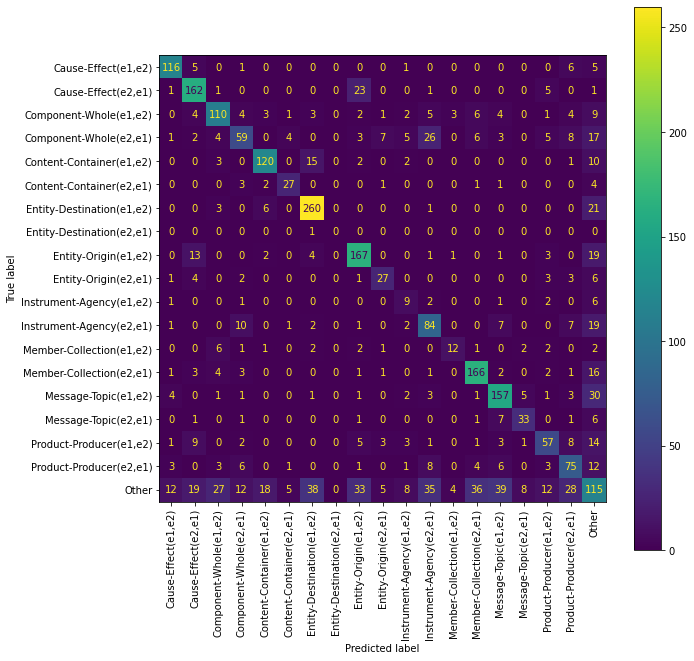

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset['train'].features['relation'].names)
disp.plot(xticks_rotation='vertical', ax=ax)
plt.show();